## **Semantic Math Types from unstructured text**

This is an overview of the Mathematics Stack Exchange Dataset and a showroom for semantic annotations of mathematical expressions

#### Importing dependencies

In [1]:
from mse_db import MSE_DBS # provides an interface for interaction with a local MongoDB instance
import funcs               # provides data processing functions
from sem_math import PostThread, \
                     FormulaContextType, \
                     FormulaType, \
                     Comparer
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from pathlib import Path

import overview_funcs

The PostThread class encapsulates one question post and all corresponding answers. The three other classes (FormulaContextType, FormulaType and Comparer) are used to determine a semantic type.

### **1. Dataset Overview**

The basic unit of the processed MSE dataset is a PostThread instance which includes one question post and all corresponding answer posts. All of these are stored within the **posts** attribute. 

![Post Thread Entry in DB](<images/post_thread_entry.png>)

A **post** entry includes general post metadata, as well as a set of tags and a **PostTypeId** which has the value 1 for question posts and a value of 2 for answer posts.

![](images/post_entry.png)

#### Setting up database connection

In [2]:
#log_file_name = "conf\log.txt"                 # processing log
#db_settings_file_name = "conf\db_conf.json"    # settings file for the database connection (local)

log_file_path = Path(".") / "conf" / "log.txt"              # processing log
db_settings_file_path = Path(".") / "conf" / "db_conf.json" # settings file for the db connection (local)

data = MSE_DBS("linux", db_settings_file_path, log_file_path) 
# counts all documents in threads collection -> ENTIRE DATASET
total_count = data.apply_once("threads", funcs.count_all_post_threads_once)     

#### Counting all documents (PostThreads) of the entire original dataset

In [3]:
print("ENTIRE dataset has {} post-threads".format(total_count))

ENTIRE dataset has 1502850 post-threads


#### Counting all documents (PostThreads) for selected mathematical categories / tags

In [4]:
sel_coll_names = ["algebra-precalculus", "analytic-geometry", "elementary-functions", \
                  "elementary-number-theory", "elementary-set-theory", "euclidean-geometry", \
                  "trigonometry"]

sel_data_size = overview_funcs.get_sel_ds_size(sel_coll_names, data)
print("\n")
print("{} post-threads".format(sel_data_size))
print("selected data is {:.2f} % of ENTIRE dataset".format(100* (sel_data_size/total_count)))

"algebra-precalculus": 43604 post-threads, number of posts: 126404 , average: 2.90
"analytic-geometry": 5934 post-threads, number of posts: 14297 , average: 2.41
"elementary-functions": 515 post-threads, number of posts: 1225 , average: 2.38
"elementary-number-theory": 34454 post-threads, number of posts: 90098 , average: 2.62
"elementary-set-theory": 26535 post-threads, number of posts: 66175 , average: 2.49
"euclidean-geometry": 8188 post-threads, number of posts: 19052 , average: 2.33
"trigonometry": 27356 post-threads, number of posts: 75653 , average: 2.77


146586 post-threads
selected data is 9.75 % of ENTIRE dataset


The project will be using only this subset of data because it is sufficiently large to demonstrate a working prototype and because questions and answers from the selected categories include the most common and widely used mathematical types and notations.

#### **2. Formula Occurence**

The **Post Thread** entry also includes a formulas attribute, which is a list of all extracted formulas / mathematical expressions. Each formula entry has an **id**, and a **latex string**, but also a **mathematical type**, a **relevant string** (if found) that describes the value and a **decision string** that explains how the program determined the type.

![Formula Entry in DB](images/formulas_entry.PNG)


#### Counting all formulas for selected mathematical categories / tags

In [5]:
sel_formulas_total = overview_funcs.get_sel_formulas_counts(sel_coll_names, data)
print("\n")
print("selected data has a total of {} formulas".format(sel_formulas_total))

"algebra-precalculus": 1014466 formulas , average: 23.27 
"analytic-geometry": 145334 formulas , average: 24.49 
"elementary-functions": 11125 formulas , average: 21.60 
"elementary-number-theory": 1144251 formulas , average: 33.21 
"elementary-set-theory": 715175 formulas , average: 26.95 
"euclidean-geometry": 224931 formulas , average: 27.47 
"trigonometry": 565353 formulas , average: 20.67 


selected data has a total of 3820635 formulas


We can see, that even from one tenth of the original dataset a very large amount of diverse mathematical expressions could be extracted. (3.8 million !)

### **3. Semantic Types Extraction** 

#### Get required data from database

In [6]:
m_type_labels  = ["SET", "FUNC", "SCAL", "UNK"]
translation_dict = { "TypeFormulaCount": "formula", \
                     "TypeContextCount": "context", \
                     "TypeContextR2Count": "context-rule 2", \
                     "TypeBothCount": "both"}
vals_list = overview_funcs.get_extracted_types_count(m_type_labels, sel_coll_names, data)
sel_coll_labels = overview_funcs.reformat_coll_names_to_labels(sel_coll_names)

#### Plot the amount of identified types (SET,FUNC,SCAL) as well as all unidentified (UNK) for different categories / tags 

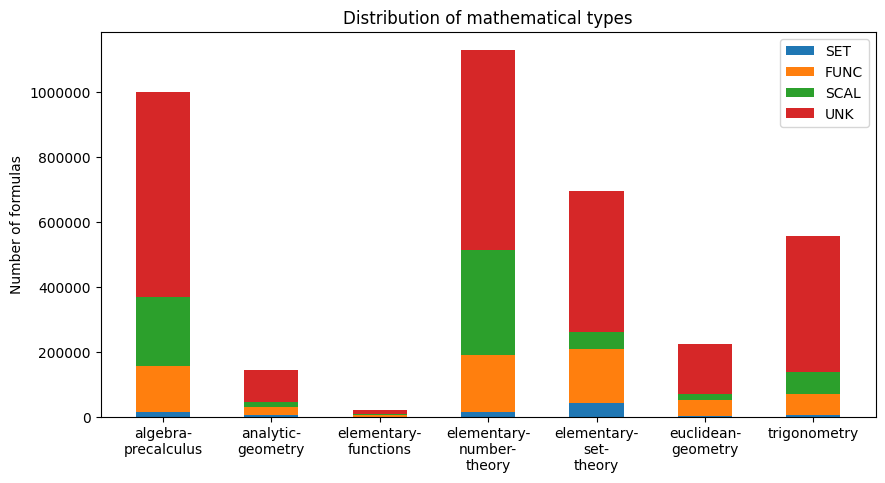

In [7]:
overview_funcs.plot_types(sel_coll_labels, vals_list, m_type_labels, \
                          "Distribution of mathematical types")

The bar chart shows the proportions of identified mathematical types across different categories. About 30 % of types were identified (the rest has been assigned the UNK type.)

#### How does the mathematical labeling work ?

There are 2 main sources of information that can be used for understanding the semantics of a mathematical expression: the expression itself which is written in a standard mathematical notation AND the surrounding textual context. <br> <br>
The **sem_math** module includes the classes **FormulaType** and **FormulaContextType** which make a type selection based on these two aspects respectively. A **Comparer** class encapsulates the mechanism to arbitrate between the 2 components if they come to different conclusions. <br> <br>
**FormulaContextType** makes a decision based on noun chunks (nominal phrases) that are related to a mathematical expression. Using a dictionary of typical keywords that describe a type (i.e. "set" or "subset" describes SET) the method searches for these strings within the related textual mentions. Two rules are used to find relevant textual mentions: <br> <br>
1.  The first noun chunk which is before a formula expression is chosen. (for example: the mathematical set A - mathematical set is chosen)
2.  If the formula expression is a subj (nsubj) and a noun is a direct object (dobj), than the nominal phrase which constitutes the object is chosen as the relevant textual mention. (for example: A is a mathematical set - since A is an expression and nsubj and mathematical set is a dobj , mathematical expression is chosen) <br> <br>

Clearly the second rule is more precise, which is why it gets the highest priority during arbitration. But as the following plots show these cases are not very frequent. <br> <br>
**FormulaType** implements a mathematical expression parser using the Lark library. Expressions are defined through context-free grammar rules. Because this method is more precise than the first contextual rule, the formal parser gets a higher priority during arbitration.

#### Assign parameters

In [8]:
figure_size = (10,19)
m_type_labels = ["SET", "FUNC", "SCAL"]
categories = list(translation_dict.values())

#### Plot amount of categorized mathematical types by the selection criteria

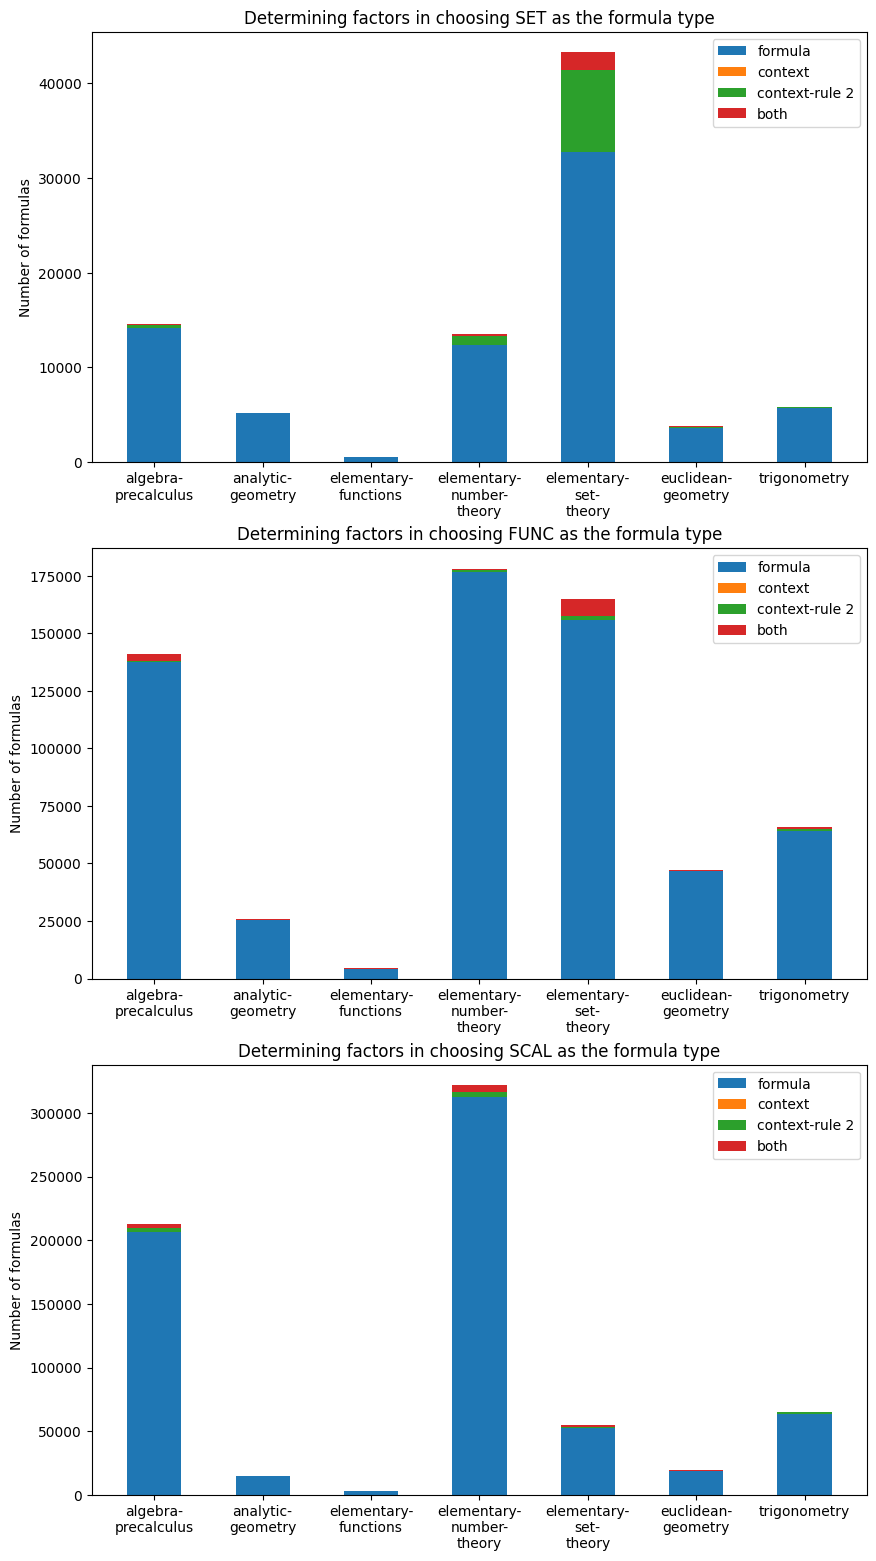

In [9]:
overview_funcs.plot_determining_factors(data, m_type_labels, sel_coll_labels, categories, figure_size)

It is important to note, that cases in which types were determined by **both** components (Formula AND Context) have a very high chance of being correct. For this reason, it makes sense to investigate such cases further.

#### Loading data for types extraction analysis

In [10]:
m_type_labels  = ["SET", "FUNC", "SCAL"]
vals_list = overview_funcs.get_determining_f_counts_both(data, m_type_labels, sel_coll_names)

#### Plot (How often do both components agree on a type across different categories?)

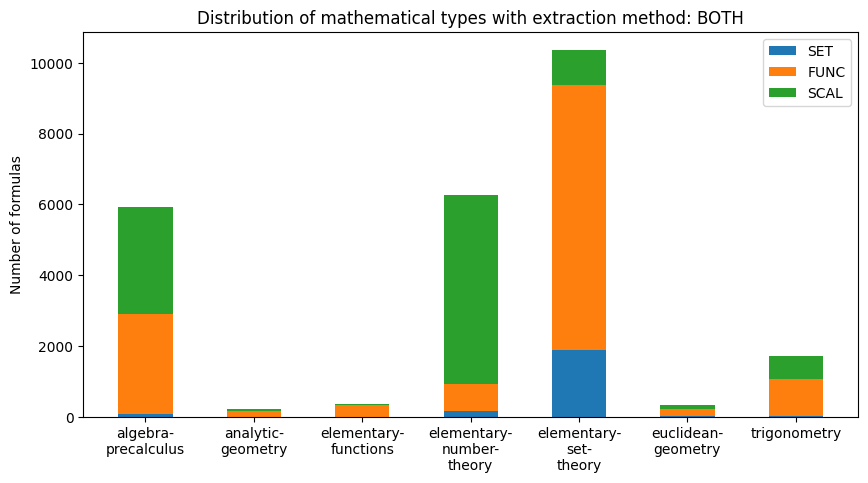

In [11]:
overview_funcs.plot_types(sel_coll_labels, vals_list, m_type_labels, \
                          "Distribution of mathematical types with extraction method: BOTH")

#### Example expressions with extraction method: BOTH

In [12]:
overview_funcs.print_examples_both(data, sel_coll_names, count_per_coll=4)

TYPE: FUNC, EXPR: f(x,y)=x/y, DESCRIPTIVE MENTION: the function
TYPE: SCAL, EXPR: \frac{a+bi}{c+di}, DESCRIPTIVE MENTION: two complex numbers
TYPE: FUNC, EXPR: g, DESCRIPTIVE MENTION: the functions
TYPE: FUNC, EXPR: g, DESCRIPTIVE MENTION: the function
TYPE: FUNC, EXPR: f, DESCRIPTIVE MENTION: the level function
TYPE: FUNC, EXPR: f, DESCRIPTIVE MENTION: functions
TYPE: FUNC, EXPR: F(x, y) = 0, DESCRIPTIVE MENTION: function
TYPE: SCAL, EXPR: 3 , DESCRIPTIVE MENTION: , z value
TYPE: FUNC, EXPR: f(x)=x, DESCRIPTIVE MENTION: , and the identity function   f_2_1_0
TYPE: FUNC, EXPR: f: \mathbb R \to \mathbb R, DESCRIPTIVE MENTION: the function   f_0_1_0
TYPE: FUNC, EXPR: f: \mathbb{N} \rightarrow \mathbb{N}, DESCRIPTIVE MENTION: function
TYPE: FUNC, EXPR: f, DESCRIPTIVE MENTION: the function
TYPE: SCAL, EXPR: 2n+1, DESCRIPTIVE MENTION: how odd numbers
TYPE: SCAL, EXPR: p - 1, DESCRIPTIVE MENTION: the three consecutive numbers
TYPE: SCAL, EXPR: 1 , DESCRIPTIVE MENTION: three consecutive number

Since these examples are chosen randomly, we can see that FUNC types appear very frequently as opposed to SET expressions. Nevertheless, this sample shows a relatively high degree of precision. Most expressions were identified correctly and the textual mention is directly related to the actual formula.  <br>
The bad positive (expr: d(t), mention: real-valued function) was labeled incorrectly because the context window was small (it missed the function keyword) and the mathematical expression parser grammar needs additional rules for better disambiguation. <br>
In general, this sample shows, that expressions where both type components (FormulaContextType and FormulaType) agree can effectively be used for semi-supervised data generation for training a machine learning sequence labeling architecture.


### **4. Extracting Dataset for Classification** 

In [13]:
m_type_labels = ["SET", "FUNC", "SCAL"]
sel_coll_names = ["algebra-precalculus"]
overview_funcs.retrieve_examples_both(data, sel_coll_names, count_per_coll=100)


ID: 6327106106a69a3f488d6eb8_f_1_0_0, TYPE: FUNC, EXPR: f(x,y)=x/y, DESCRIPTIVE MENTION: the function, TOKENS: ['f', '(', 'x', ',', 'y', ')', '=', 'x', '/', 'y']
ID: 6327106106a69a3f488d6f55_f_3_0_0, TYPE: SCAL, EXPR: \frac{a+bi}{c+di}, DESCRIPTIVE MENTION: two complex numbers, TOKENS: ['\\frac', '{', 'a', '+', 'b', 'i', '}', '{', 'c', '+', 'd', 'i', '}']
ID: 6327106106a69a3f488d6f5c_f_5_0_0, TYPE: FUNC, EXPR: g, DESCRIPTIVE MENTION: the functions, TOKENS: ['g']
ID: 6327106106a69a3f488d6f5c_f_5_4_0, TYPE: FUNC, EXPR: g, DESCRIPTIVE MENTION: the function, TOKENS: ['g']
ID: 6327106106a69a3f488d6f5c_f_5_7_0, TYPE: FUNC, EXPR: g, DESCRIPTIVE MENTION: every function   f_5_7_0, TOKENS: ['g']
ID: 6327106106a69a3f488d6f5c_f_5_14_0, TYPE: FUNC, EXPR: f, DESCRIPTIVE MENTION: The function, TOKENS: ['f']
ID: 6327106206a69a3f488d705d_f_0_0_0, TYPE: FUNC, EXPR: f:Y\to Z, DESCRIPTIVE MENTION: an invertible function, TOKENS: ['f', ':', 'Y', '\\to', 'Z']
ID: 6327106206a69a3f488d710b_f_2_2_0, TYPE: SCAL